In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
import torch
from chronos import BaseChronosPipeline
from models import predict_chronos
from chronos import BaseChronosPipeline
from tqdm import tqdm
from timeseries import PredictionLeadTime, PredictionLeadTimes, TabularDataFrame
from sklearn.linear_model import QuantileRegressor
import joblib

In [3]:
# read in data. Here only using data from 2021-2025 for first tests
df = pd.read_csv("data/Realisierter_Stromverbrauch_202103010000_202503270000_Stunde.csv", thousands=".", decimal=",", sep=";")

# bring data in right shape
for col in df.columns[2:]:
    df[col] = df[col].str.replace('.', '')
    df[col] = df[col].str.replace(',', '.').replace("-",np.nan).astype(float)
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp", "Netzlast [MWh] Berechnete Auflösungen": "target"})
df["item_id"] = 0 
df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True)
df = df.drop_duplicates(subset=["item_id","timestamp"], keep="first")

In [4]:
df.tail(20)

,timestamp,target,item_id
35668,2025-03-26 04:00:00,46351.50,0
35669,2025-03-26 05:00:00,49857.25,0
35670,2025-03-26 06:00:00,56725.50,0
35671,2025-03-26 07:00:00,60778.00,0
35672,2025-03-26 08:00:00,63646.00,0
35673,2025-03-26 09:00:00,64506.75,0
35674,2025-03-26 10:00:00,65507.25,0
35675,2025-03-26 11:00:00,66186.00,0
35676,2025-03-26 12:00:00,65441.00,0
35677,2025-03-26 13:00:00,64230.50,0


In [5]:
# create TimesSeriesDataFrame
data = TimeSeriesDataFrame(df)
# split data in train and test
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2023"))

# Chronos Bolt Zero Shot

In [ ]:
# load model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny", # could also use e.g. "amazon/chronos-bolt-small", "amazon/chronos-bolt-base", "amazon/chronos-bolt-large"
    device_map="mps", # mps for using mac gpu
)

In [42]:
predictions_raw = predict_chronos(pipeline=pipeline, 
                                  data=data_test, 
                                  lead_times=np.arange(1,65),
                                  freq=pd.Timedelta("1h"))

100%|██████████| 306/306 [00:12<00:00, 24.62it/s]


In [16]:
# calculate crps for all lead times (1 to 64)
predictions_raw.get_crps()

{1: 614.4922082008098,
 2: 747.6605021673224,
 3: 837.1297197573348,
 4: 913.5434796784774,
 5: 970.9978606360938,
 6: 1020.2504691341857,
 7: 1061.9064708492872,
 8: 1088.654438207666,
 9: 1118.0452493108444,
 10: 1149.7327961767571,
 11: 1173.0910850823134,
 12: 1196.759311830442,
 13: 1214.3868745828363,
 14: 1235.7120379706735,
 15: 1249.3958284853063,
 16: 1256.0256565952338,
 17: 1267.980736655843,
 18: 1280.3071609953408,
 19: 1285.3103992154383,
 20: 1293.3891583714596,
 21: 1293.561713728224,
 22: 1299.0475025907137,
 23: 1309.4899926945686,
 24: 1321.525632761391,
 25: 1354.2864667381255,
 26: 1382.3296481179798,
 27: 1407.232484317177,
 28: 1432.1941530002875,
 29: 1453.2372872633189,
 30: 1471.4694895959478,
 31: 1479.1360729894266,
 32: 1482.3636916406886,
 33: 1486.815754035525,
 34: 1490.7739028020349,
 35: 1499.8664466502598,
 36: 1502.7350481840367,
 37: 1502.666816012568,
 38: 1510.8839419275942,
 39: 1516.4980372616867,
 40: 1522.6769087009804,
 41: 1525.330555365340

In [17]:
# alternatively only get results for certain lead times (in h)
predictions_raw.get_crps([1, 12, 24, 32, 48, 64])

{1: 614.4922082008098,
 12: 1196.759311830442,
 24: 1321.525632761391,
 32: 1482.3636916406886,
 48: 1542.8868614432174,
 64: 1703.8207140067298}

In [18]:
# get empirical coverage rates
predictions_raw.get_empirical_coverage_rates([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,0.025789,0.080125,0.077673,0.081248,0.089981,0.096109
0.2,0.097487,0.174599,0.177255,0.163262,0.179144,0.174037
0.3,0.201818,0.263967,0.278317,0.248749,0.272853,0.257379
0.4,0.323818,0.358952,0.376826,0.337861,0.370187,0.347360
0.5,0.463283,0.457614,0.466193,0.427740,0.466653,0.443009
0.6,0.608773,0.559544,0.566796,0.520887,0.563017,0.542794
0.7,0.752426,0.671586,0.667756,0.623634,0.662905,0.650087
0.8,0.878919,0.789194,0.780360,0.737872,0.768818,0.758554
0.9,0.971862,0.910888,0.907875,0.876162,0.895567,0.883158


<Figure size 800x800 with 0 Axes>

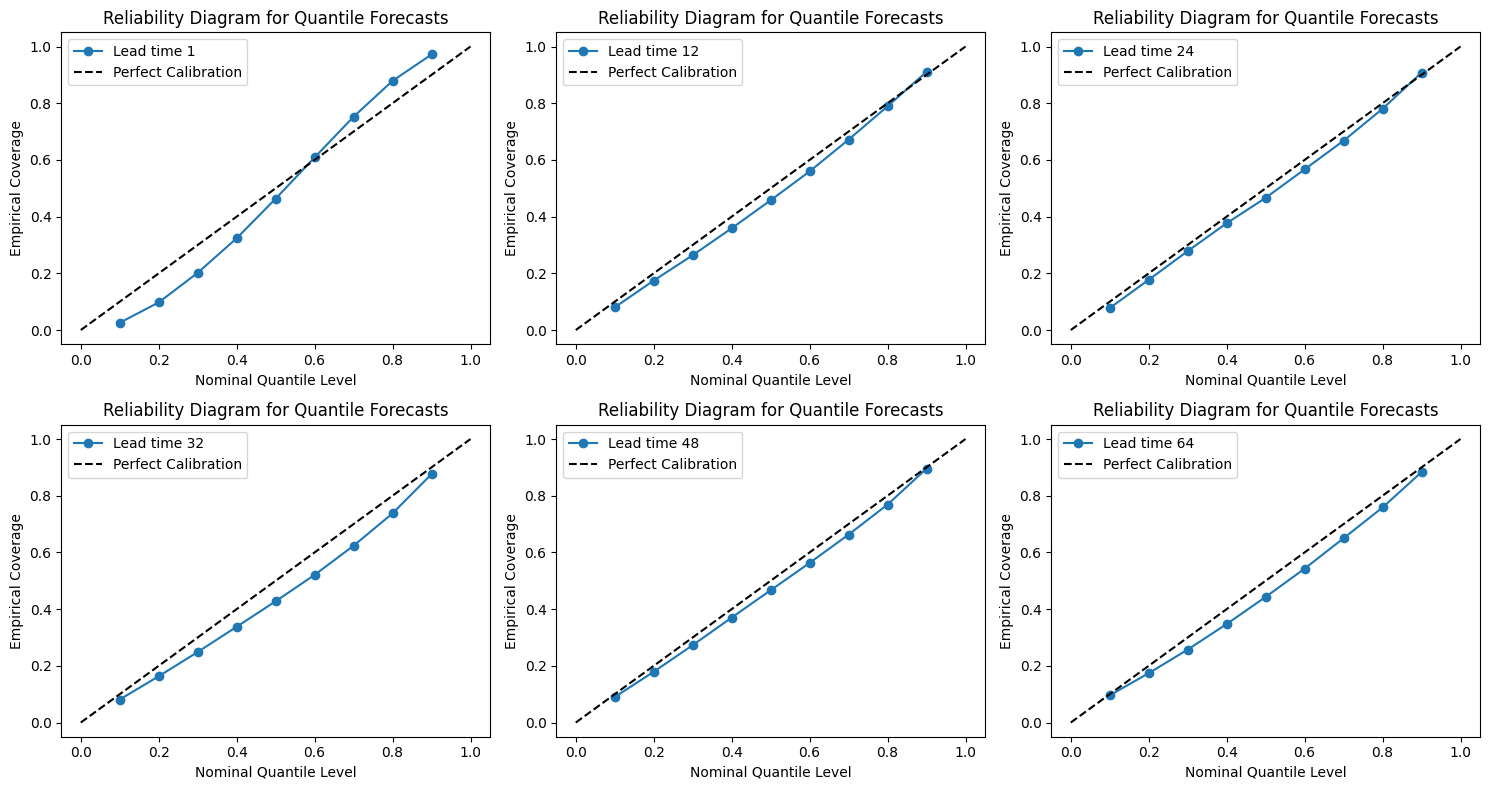

In [19]:
# plot reliability diagrams
predictions_raw.get_reliability_diagram([1, 12, 24, 32, 48, 64])

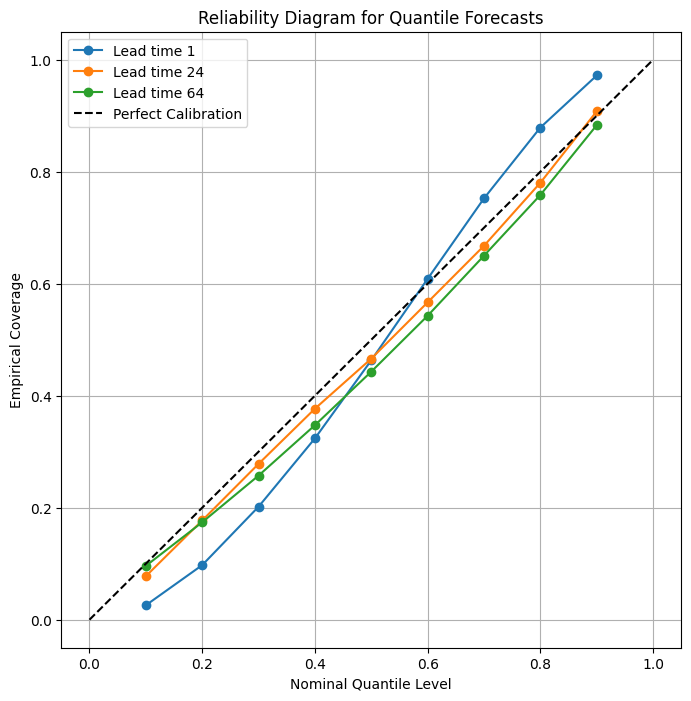

In [20]:
# use overlay
predictions_raw.get_reliability_diagram([1, 24, 64], overlay=True)

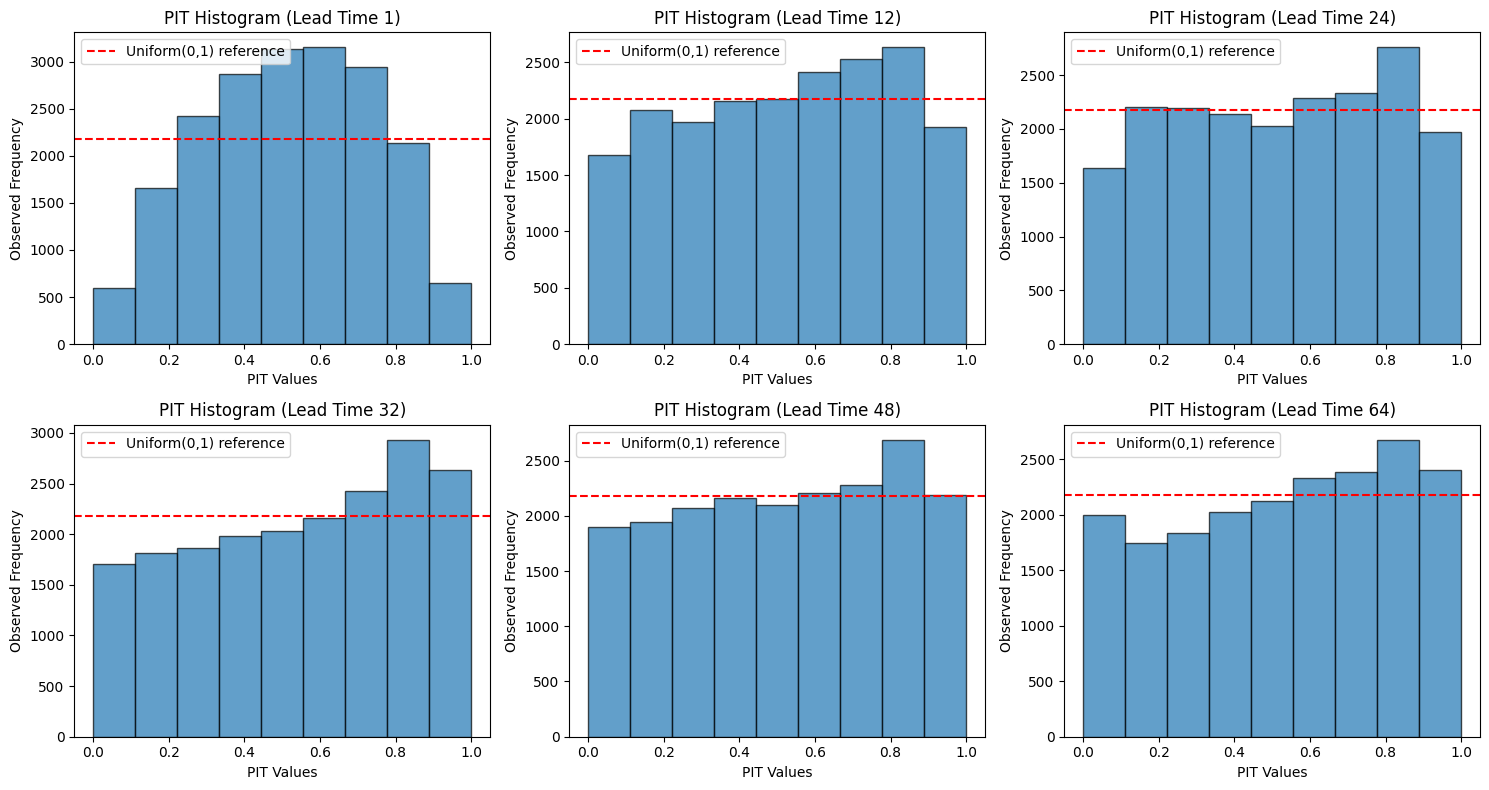

In [21]:
# plot PIT histograms
predictions_raw.get_pit_histogram([1, 12, 24, 32, 48, 64])

# Postprocessing

## Parametric Approximation of Log-Normal Distribution
- (V1) Fitte Normalverteilung für log Y, mit folgender Parametrisierung: mean = a + b*M, wobei M = Median-Vorhersage des Modells für log Y. Standardabweichung = c + d*IQR, wobei IQR = Interquartilsabstand (z.B. 90%-10%) des Modells für log Y. Falls sich die Modellvorhersagen anfangs auf Y (statt log Y) beziehen kannst Du die einfach logarithmieren, das ist einer der Vorteile von Quantilen.

In [ ]:
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

In [ ]:
# get zero shot predictions on training dataset
predictions_train = predict_chronos(pipeline=pipeline, 
                                    data=data_train, 
                                    lead_times=np.arange(1,65),
                                    freq=pd.Timedelta("1h"))

check if data is normally distributed

In [143]:
# get target variable
log_target = np.log(predictions_train.results[1].data["target"])

<Axes: >

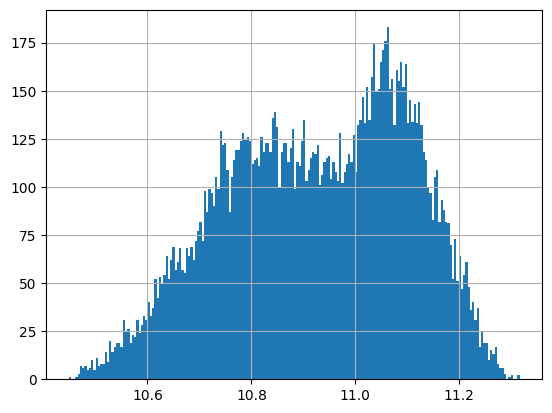

In [144]:
# plot histogram of target variable
log_target.hist(bins=200)

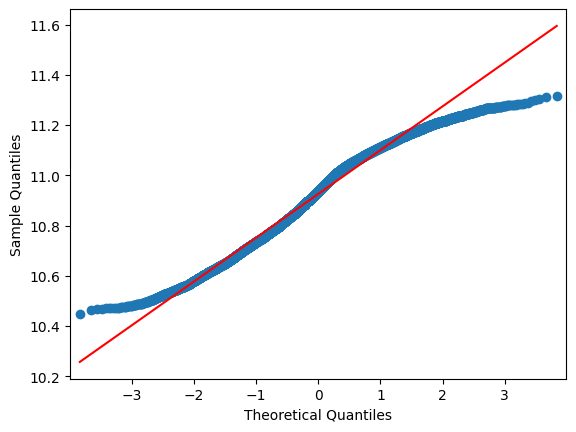

In [139]:
# q-q plot
qqplot(log_target, line='s')
plt.show()

In [ ]:
# normality test
# The D’Agostino and Pearson’s test calculates summary statistics from the data, namely kurtosis and skewness, 
# to determine if the data distribution departs from the normal distribution.
stat, p = normaltest(log_target)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=1638.543, p=0.000
Sample does not look Gaussian (reject H0)


"Netzlast [MWh]" does not seem to be normally distributed. Still implement post-processing method since we haven't decided on the actual time series.

In [98]:
freq = pd.Timedelta("1h")
lead_time = list(predictions_raw.results.keys())
results_nrml = {}

for lt in lead_time:
    # estimate mean and std (a, b, c, d) with linear regression using train data
    
    prediction_train = predictions_train.results[lt]
    quantile_levels = predictions_train.results[lt].quantiles
    
    df_train = prediction_train.to_dataframe().dropna().copy()
    # TODO: make this nicer. Discard the first 100 entries 
    df_train = df_train.iloc[100:].copy()
    log_df_train = np.log(df_train[quantile_levels + ["target"]])

    # estimate mean=a+b*Median
    x_mu = sm.add_constant(log_df_train[0.5])
    y_mu = log_df_train["target"] 
    model_mu = sm.OLS(y_mu, x_mu).fit()
    # a, b = model_mu.params

    # calculate std deviation of log Y based on expanding window
    #log_df_train["std_target"] = log_df_train["target"].groupby("item_id").expanding(min_periods=100).std().droplevel(0)
    log_df_train["std_target"] = log_df_train["target"].groupby("item_id").rolling(100, min_periods=100).std().droplevel(0)

    log_df_train = log_df_train.dropna()
    iqr = log_df_train[0.9]-log_df_train[0.1]
    x_sigma = sm.add_constant(iqr)
    y_sigma = log_df_train["std_target"]
    model_sigma = sm.OLS(y_sigma, x_sigma).fit()
    # c, d = model_sigma.params

    # test performance
    df_test = predictions_raw.results[lt].to_dataframe().copy()
    # TODO: make this nicer
    df_test = df_test.iloc[100:]
    log_pred_test = np.log(df_test[quantile_levels + ["target"]])

    x_mu = sm.add_constant(log_pred_test[0.5])
    mean_est = model_mu.predict(x_mu)

    iqr = log_pred_test[0.9]-log_pred_test[0.1]
    x_sigma = sm.add_constant(iqr)
    std_est = model_sigma.predict(x_sigma)

    log_predictions = norm.ppf(np.array(quantile_levels).reshape(-1,1), loc=mean_est, scale=std_est).T
    predictions = np.exp(log_predictions)

    results_nrml[lt] = PredictionLeadTime(lead_time=lt,
                                        predictions=torch.tensor(predictions),
                                        quantiles=quantile_levels,
                                        freq=predictions_raw.results[lt].freq,
                                        data=predictions_raw.results[lt].data.iloc[100:])


predictions_nrml = PredictionLeadTimes(results=results_nrml)

In [110]:
predictions_nrml.get_crps()

{1: 2106.1483284536116,
 2: 2138.3547365448817,
 3: 2165.2486857334166,
 4: 2191.3842412013373,
 5: 2211.6502319859587,
 6: 2229.08498723638,
 7: 2244.878113933089,
 8: 2256.4593833304752,
 9: 2267.694202930184,
 10: 2281.9988275683986,
 11: 2293.75327258465,
 12: 2305.6656562721987,
 13: 2313.554513672937,
 14: 2322.4375602570094,
 15: 2329.818940942152,
 16: 2332.1814176856124,
 17: 2335.9413959816757,
 18: 2342.699538529669,
 19: 2346.546350227645,
 20: 2350.077969879895,
 21: 2350.8382258917736,
 22: 2354.6602005567966,
 23: 2359.3411423395673,
 24: 2363.123576550525,
 25: 2370.9237599125318,
 26: 2378.947071331986,
 27: 2387.8326025304254,
 28: 2396.2285751267514,
 29: 2403.671095804034,
 30: 2410.343697458615,
 31: 2414.7275954784313,
 32: 2417.4431345103017,
 33: 2419.906868400436,
 34: 2423.950244902356,
 35: 2429.6065726268625,
 36: 2432.6479942567353,
 37: 2433.565903642194,
 38: 2436.760558319651,
 39: 2440.164602976617,
 40: 2441.3711089040808,
 41: 2442.286289220306,
 42: 

<Figure size 800x800 with 0 Axes>

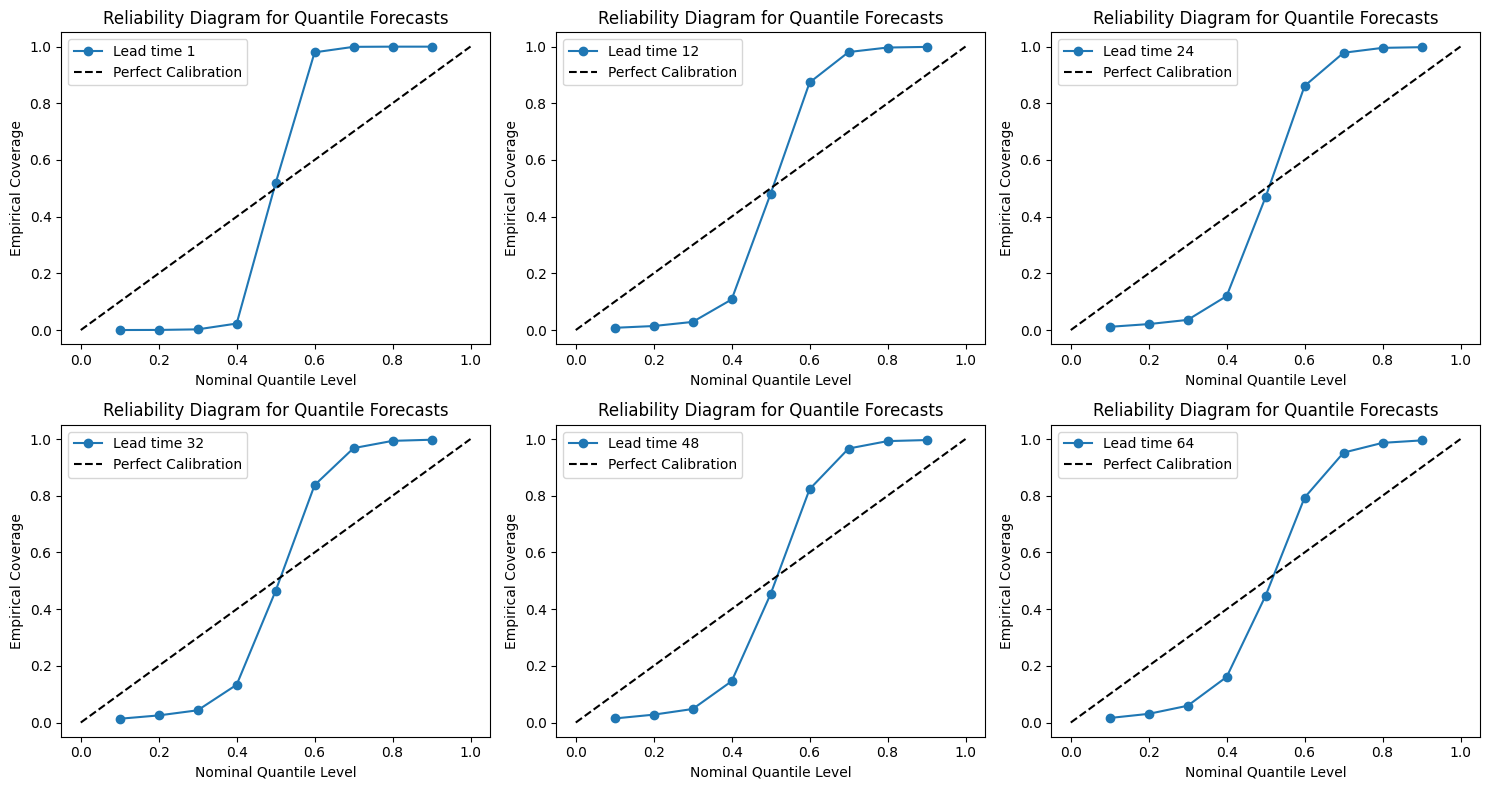

In [ ]:
predictions_nrml.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

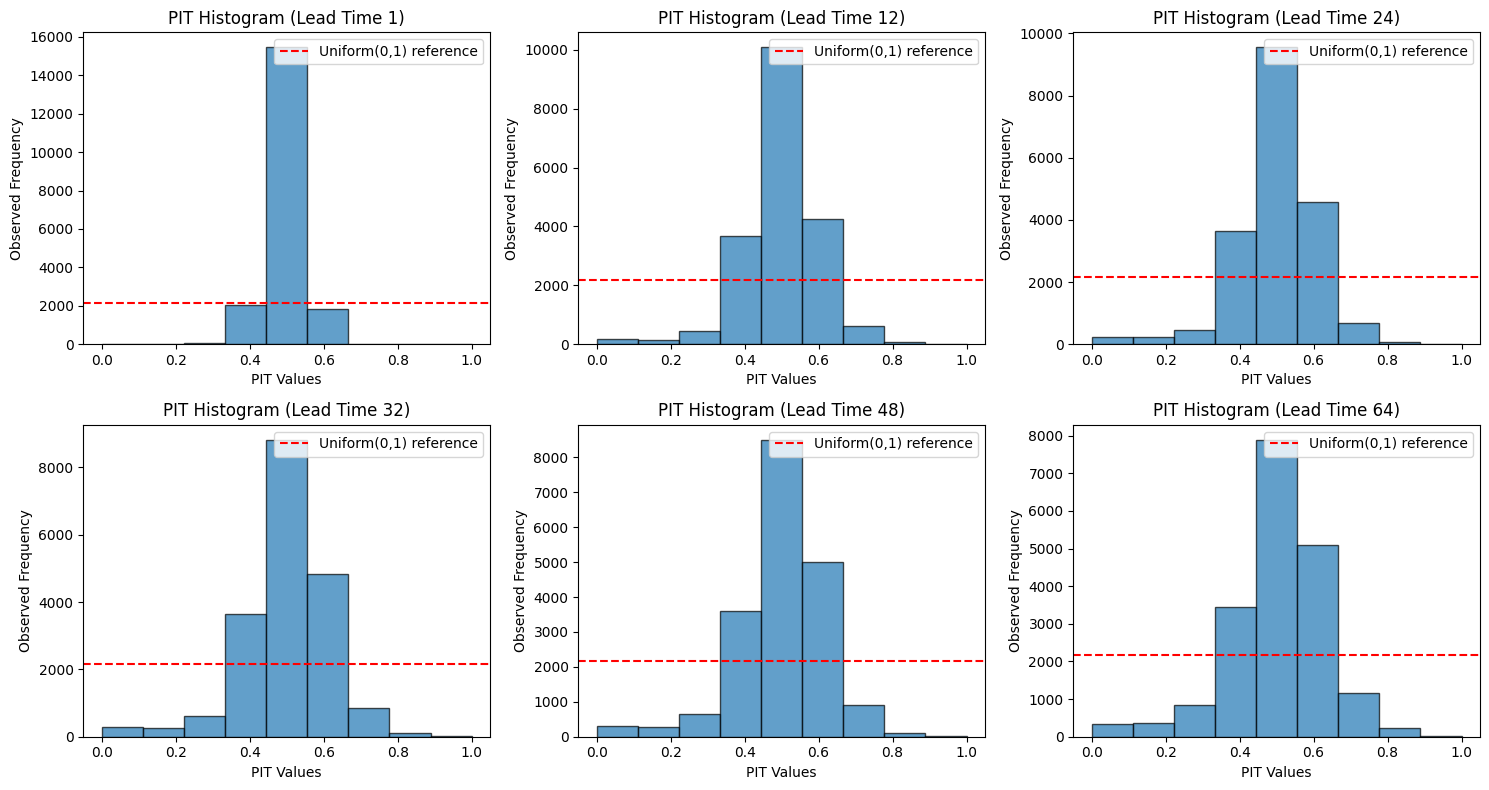

In [128]:
predictions_nrml.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

## Quantile Regression

-  (V2) Fitte separate Quantilsregression für jedes Quantil (z.B. 10%, 20%, ..., 90%). D.h. für jedes Level eine Quantilsregression mit Konstante und einem Regressor (= Quantils-Vorhersage des Modells). Der Spezialfall mit Konstante = 0 und Slope = 1 würde dann heißen, dass die Vorhersagen bereits perfekt kalibriert sind.


- Current issues: quantile regression implementation is quite slow. Only fitting the models on a very small subset of the training data



In [13]:
# get zero shot predictions on training dataset
predictions_train = predict_chronos(pipeline=pipeline, 
                                    data=data_train, 
                                    lead_times=np.arange(1,65),
                                    freq=pd.Timedelta("1h"))

100%|██████████| 252/252 [00:10<00:00, 24.66it/s]


In [ ]:
freq = pd.Timedelta("1h")
lead_time = list(predictions_raw.results.keys())
results_qr = {}

for lt in tqdm(lead_time):
    
    quantiles = predictions_raw.results[lt].quantiles

    # prepare predictions for postprocessing
    prediction_test = predictions_raw.results[lt].to_dataframe().dropna()
    prediction_train = predictions_train.results[lt].to_dataframe().dropna()
    cols_rename = {q: f"feature_{q}" for q in quantiles}
    prediction_test = prediction_test.rename(columns=cols_rename)
    prediction_train = prediction_train.rename(columns=cols_rename)
    cols_to_keep = list(cols_rename.values()) + ["target"]# TODO: issues with speed of quantile regression
    train_data = TabularDataFrame(prediction_train[cols_to_keep])
    test_data = TabularDataFrame(prediction_test[cols_to_keep])

    # store results
    qr_models = {}
    test_results = {}

    # fit a quantile regression for each quantile and make predictions on test dataset
    for q in quantiles:

        x_train = train_data[f"feature_{q}"].values.reshape(-1, 1)
        y_train = train_data["target"].values
        x_test = test_data[f"feature_{q}"].values.reshape(-1, 1)
        y_test = test_data["target"].values

        qr_models[q] = QuantileRegressor(quantile=q)
        
        # TODO: training is very slow, only use small subset
        qr_models[q].fit(x_train[-1000:], y_train[-1000:])

        test_results[q] = qr_models[q].predict(x_test)

    results_qr[lt] = PredictionLeadTime(lead_time=lt,
                                    predictions=torch.tensor(np.array(list(test_results.values())).T),
                                    freq=freq,
                                    data=test_data)

predictions_qr = PredictionLeadTimes(results=results_qr)

100%|██████████| 64/64 [16:54<00:00, 15.86s/it]


In [25]:
# save predictions
joblib.dump(predictions_qr, "data/predictions_postprocessed_qr.joblib")

['data/predictions_postprocessed_qr.joblib']

In [26]:
predictions_qr.get_crps()

{1: 572.8291456751732,
 2: 728.6081745625861,
 3: 821.486755334945,
 4: 901.4657691036068,
 5: 965.2960644997382,
 6: 1018.0856769375337,
 7: 1063.4527503897696,
 8: 1092.6766757749083,
 9: 1122.4785340791907,
 10: 1158.808475361335,
 11: 1180.6013934569417,
 12: 1200.3277977859573,
 13: 1216.1035129620882,
 14: 1240.1661060619117,
 15: 1254.8682865889662,
 16: 1260.9131638024005,
 17: 1274.5930452538303,
 18: 1292.974280960048,
 19: 1297.4824900218507,
 20: 1299.3338060772105,
 21: 1301.9491883539604,
 22: 1303.3560014576078,
 23: 1314.9848279377063,
 24: 1325.1823738078374,
 25: 1350.1231644012814,
 26: 1376.7405048880828,
 27: 1399.8972427937392,
 28: 1425.749657370681,
 29: 1446.0180669357394,
 30: 1463.9360325373905,
 31: 1477.6979490234146,
 32: 1485.5192253277091,
 33: 1493.116422472767,
 34: 1508.9159339111086,
 35: 1518.9109252763276,
 36: 1520.201659168443,
 37: 1526.5600030419735,
 38: 1535.5492158174995,
 39: 1542.3317941541636,
 40: 1545.382729591034,
 41: 1546.97791087866

In [27]:
predictions_qr.get_quantile_scores()

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
0.1,173.823520,222.272043,257.383580,288.565102,316.639101,336.102860,351.474479,366.006703,374.015929,384.399136,...,742.910079,741.508333,752.697451,759.560470,746.809862,763.984553,771.986336,767.080396,763.203896,759.149611
0.2,267.195946,339.360606,385.747909,428.455661,464.179580,488.438078,509.704797,526.330971,538.704815,552.368610,...,861.721714,858.665382,859.550519,871.989729,870.010868,869.657349,870.007845,880.419438,889.396409,902.591879
0.3,325.472769,411.129763,465.590694,513.063982,551.756050,580.872574,605.638466,623.657192,636.053414,654.512662,...,945.241827,943.311786,950.055567,959.508887,957.238258,959.816337,958.483575,969.223340,974.942081,990.291928
0.4,355.196773,450.607809,507.740127,557.698669,595.638508,627.473168,657.099739,676.813016,692.609117,712.715972,...,992.427678,996.405998,1007.992241,1017.344780,1013.397900,1014.134366,1013.944469,1028.042727,1032.549006,1045.990724
0.5,363.515879,462.112654,518.792209,567.859420,605.801815,639.146410,669.402952,687.855783,703.988711,727.648664,...,990.752307,992.747209,1006.723318,1016.955912,1015.876375,1016.285506,1015.400161,1024.938708,1034.022262,1043.955546
0.6,350.455500,447.122116,501.441135,545.882711,579.782138,611.823665,641.175596,657.400214,679.158185,701.782571,...,944.259836,948.646692,958.437656,967.980606,967.452585,968.701590,967.308592,980.439078,983.940909,996.424514
0.7,317.518231,404.164184,453.503924,492.354931,523.789238,551.753480,578.255914,593.906013,612.218540,634.975555,...,840.127182,844.215182,853.382191,861.497584,862.150302,861.776275,860.116332,874.553596,879.050440,887.578335
0.8,258.768353,329.683791,369.832745,402.571527,430.485774,452.787963,469.638259,478.173761,498.014233,516.582008,...,675.592491,677.156959,682.388984,692.357312,696.057903,695.522726,695.428948,703.987897,710.152858,714.836726
0.9,165.784184,212.283819,236.658075,260.143959,275.760086,292.987348,303.147175,306.901388,316.390460,329.652960,...,431.302128,431.261436,436.362796,442.998210,447.563341,447.907242,447.638299,454.772943,459.624301,463.176581


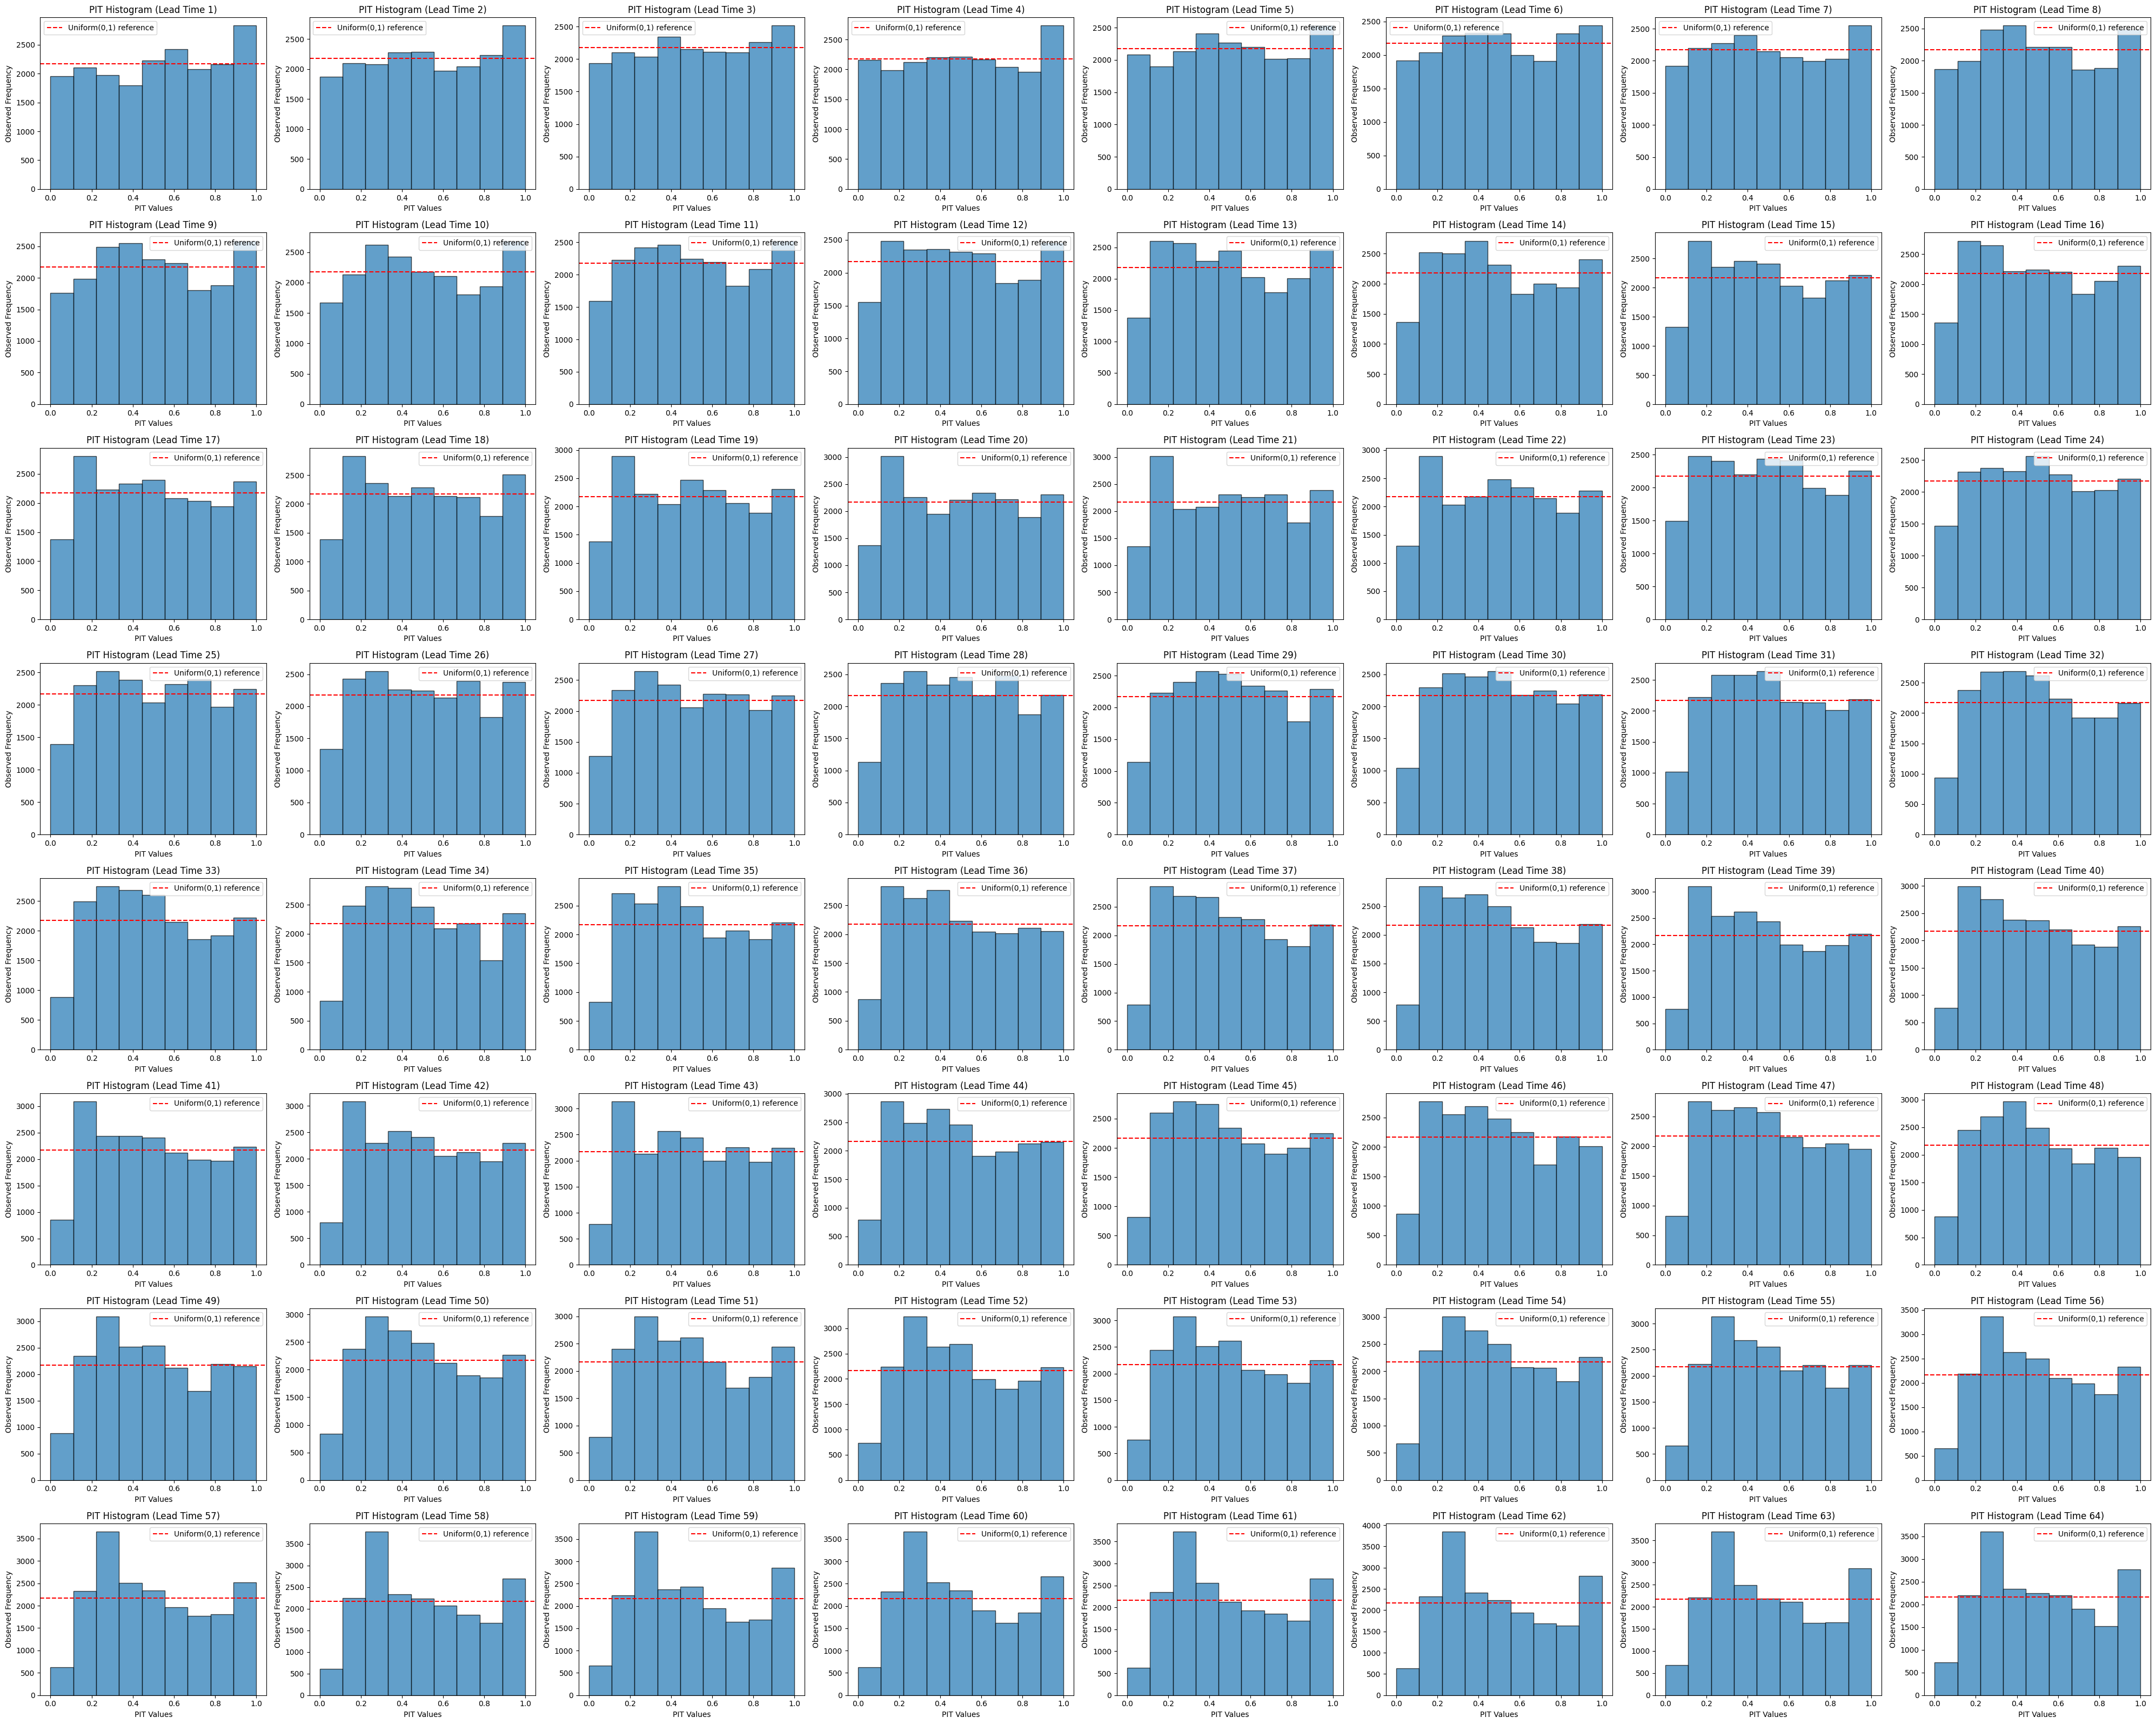

In [28]:
predictions_qr.get_pit_histogram()